# Matlab Implementation - DvKalman1
<img src= "plot_pos.png" width ="300"> <img src= "plot_vel.png" width ="300">

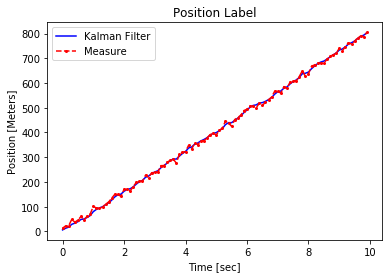

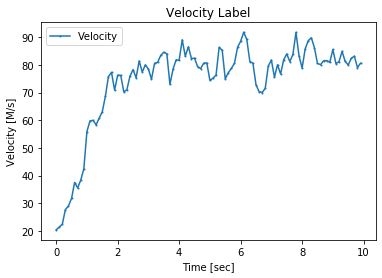

In [1]:
# Libraries used in this code
import numpy as np
import matplotlib.pyplot as plot
import KalmanTools as Tools
np.random.seed(42)


# instantiate generator and lists signals for plot
dt = 0.1
t = np.arange(0, 10, dt)
NSamples = len(t)
position = Tools.GetPos()
XSaved = np.zeros((2, NSamples))
ZSaved = np.zeros(NSamples)

Kalman = Tools.KalmanFilter()
Kalman.dt = dt
for k in range(NSamples):
    z = ZSaved[k] = next(position)
    XSaved[0:2, k] = Kalman.dv_filter(z)


first_plot, pos_plot = plot.subplots()
second_plot, vel_plot = plot.subplots()
pos_plot.plot(t, XSaved[0], 'b-', label='Kalman Filter')
pos_plot.plot(t, ZSaved, 'ro--', label='Measure', markersize=2)
pos_plot.set(title="Position Label", xlabel="Time [sec]", ylabel="Position [Meters]")
leg_1 = pos_plot.legend()


vel_plot.plot(t, XSaved[1], 'o-', label='Velocity', markersize=1)
vel_plot.set(title="Velocity Label", xlabel="Time [sec]", ylabel="Velocity [M/s]")
leg_2 = vel_plot.legend()




# Matlab Implementation - DvKalman2
<img src= "plot_pos_sonar.png" width ="300"> <img src= "plot_vel_sonar.png" width ="300">

# Python implementation - DeDvKalman2

500


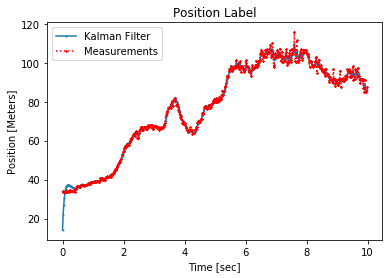

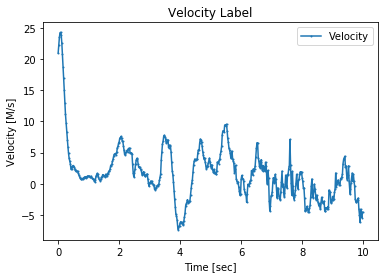

In [8]:
# Libraries used in this code
import numpy as np
import matplotlib.pyplot as plot
import KalmanTools as Tools

# generate and lists signals for plot
ZSaved, NSamples = Tools.GetSonar()
XSaved = np.zeros((2, NSamples))
dt = 0.02
t = np.arange(0, 10, dt)

# define class 'Kalman' to use it's internal modules
DvKalman = Tools.KalmanFilter()
DeKalman = Tools.KalmanFilter()
DeKalman.dt = DvKalman.dt = dt
# iteration to generate XSaved list
for k in range(NSamples):
    A = DvKalman.dv_filter(ZSaved[k])
    XSaved[0:2, k] = A

# plotting results
plot_1, position = plot.subplots()
plot_2, velocity = plot.subplots()

position.plot(t, XSaved[0], 'o-', label='Kalman Filter', markersize=1)
position.plot(t, ZSaved, 'r:*', label='Measurements', markersize=2)

position.set(title="Position Label", xlabel="Time [sec]", ylabel="Position [Meters]")
leg_1 = position.legend()


velocity.plot(t, XSaved[1], 'o-', label='Velocity', markersize=1)
velocity.set(title="Velocity Label", xlabel="Time [sec]", ylabel="Velocity [M/s]")
leg_2 = velocity.legend()
plot.show()


# KalmanTools Class Implementation (Python)

In [1]:
%%writefile KalmanTools.py
import numpy as np

def GetSonar():
    """
    This function simulates as an sonar, sending back a list of
    values and its total samples that comes from GetSonar.csv
    :return:
    1)measures: An array list related to salved values in GetSonar.csv
    2)Samples: The total values obtained by the file
    """
    file_name = 'GetSonar.csv'
    file = open(file_name)
    data = file.read()
    measures = data.split(';')
    Samples = len(measures)
    file.close()
    measures = [float(x) for x in measures]
    return measures, Samples

def GetPos(dt=0.1):
    """
    This function returns velocity and position as output.
    Although, it's return contains noises, like a sensor.
    :param dt: (optional) instantiate at start of the program
    :return: measured position of the object
    """
    posp = 0
    velp = 80
    i = 0
    while True:
        v = 0 + 10 * np.random.randn()
        w = 0 + 10 * np.random.randn()
        i += 1
        value = posp + velp * dt + v
        posp = value - v  # true position
        velp = 80 + w  # true speed
        yield value

class KalmanFilter:
    # You should avoid to use at the same object the following 
    # functions: dv_filter and de_filter
    def __init__(self):
        self.dt = 0.1
        self.A = np.matrix([[1., self.dt],
                            [0., 1.]])

        self.H = np.matrix([1., 0.])

        self.Q = np.matrix([[1., 0.],
                            [0., 3.]])

        self.R = np.matrix([10.])
        
        self.x = np.matrix([0., 20.]).getT()
        self.P = 5 * np.identity(2)
        self.dv_z: float
        self.de_z: float
        self.K = np.zeros((2, 1))

    def dv_filter(self, dv_position):
        self.dv_z = dv_position
        xp = self.A * self.x
        Pp = self.A * self.P * self.A.getT() + self.Q
        self.K = Pp * self.H.getT() * np.matrix.getI(self.H * Pp * self.H.getT() + self.R)
        self.x = xp + self.K * (self.dv_z - self.H * xp)
        self.P = Pp - self.K * self.H * Pp
        dv_pos = self.x[0, 0]
        dv_vel = self.x[1, 0]
        return dv_pos, dv_vel

    def de_filter(self, de_position):
        self.de_z = de_position
        xp = self.A * self.x
        Pp = self.A * self.P * self.A.getT() + self.Q
        self.K = 1 / (Pp[0, 0] + self.R) * np.matrix([Pp[0, 0], Pp[1, 0]])
        # (Comment the next one)
        self.x = xp + self.K * (self.de_z - self.H * xp)
        self.P = Pp - self.K * self.H * Pp
        de_pos = self.x[0, 0]
        de_vel = self.x[1, 0]
        return de_pos, de_vel


Overwriting KalmanTools.py


# DPC++ implementation

In [39]:
%%writefile DvKalman.cpp
#include <iostream>
using std::cout;
using std::endl;
#include <fstream>
using std::ifstream; 
using std::ofstream; 
#include <stdlib.h>
#include <string>
using std::stof;
using std::string;
#include <limits>
#include <random>
#include <CL/sycl.hpp>
#include "oneapi/mkl.hpp"
namespace blas = oneapi::mkl::blas;
namespace lapack = oneapi::mkl::lapack;
#include "KalmanTools.h"

//Function Prototype
double *Getsonar();

int main(){
    //create file : DvKalman
    ofstream myfile("DvKalman.csv");
    myfile << "Time,Measurements,Position,Velocity\n";
    auto async_handler = [](sycl::exception_list exceptions) {
        for (exception_ptr const &e : exceptions) {
            try {
                rethrow_exception(e);
            }
            catch (sycl::exception const &e) {
                cout << "Caught asynchronous SYCL exception: " << e.what() << endl;
            }
        }
    };
    
    try {
        //Define pseudo-random values and normal distribution
        default_random_engine generator;
        generator.seed(42);
        normal_distribution<double> distribution(0.0, 1.0);
         
        //About Accelerator Device & Queue
        sycl::device device = sycl::device(sycl::default_selector());
        cout << "Device: " << device.get_info<sycl::info::device::name>() << "\n";
        sycl::queue queue(device, async_handler);
        vector<sycl::event> event_list;
        
        //Declare example variables, lists and Kalman Object
        double dt = 0.02;
        const int Nsamples = 500;
        double t[Nsamples];
        Kalman_filter *kalman = new Kalman_filter();
        kalman->default_values(dt);
        auto *Zsaved = sycl::malloc_shared<double>(Nsamples, queue);
        auto *PosSaved = sycl::malloc_shared<double>(Nsamples, queue);
        auto *VelSaved = sycl::malloc_shared<double>(Nsamples, queue);
        
        //generate list with Sonar measures
        Zsaved = Getsonar();
        
        if (!PosSaved || !VelSaved) {
            cerr << "Could not allocate memory for vectors." << endl;
            exit(1);
        }
        int first = 0;
        for (int i = 0; i < Nsamples; i++){
            t[i] = dt*i;
            //calculate, then store.
            kalman->filter(Zsaved[i]);
            PosSaved[i] = kalman->getResult(0,0);
            VelSaved[i] = kalman->getResult(0,1);
            myfile << t[i] << ", " << Zsaved[i] << ", " << PosSaved[i] << ", " << VelSaved[i] <<'\n';
        }
        myfile.close();
        free(PosSaved, queue);
        free(VelSaved, queue);
        free(Zsaved, queue);
        

    } catch (const exception &e) {
        cerr << "An exception occurred: "
                  << e.what() << endl;
        exit(1);
    }
}

double *Getsonar() {
	string Mytext;
	int i= 0, NSamples = 500;
	double *arr = new double[500];
	//Leitura de arquivo
    ifstream MyFile("GetSonar.csv");
 while(getline(MyFile, Mytext,';')){
	arr[i++] = stof(Mytext);
 }
 return arr;
}



Overwriting DvKalman.cpp


# KalmanTools Class Implementation (DPC++)

In [10]:
%%writefile KalmanTools.h


#include <iostream>

#include <fstream>
#include <stdlib.h>
#include <stdio.h>
#include <limits>
#include <CL/sycl.hpp>
#include "oneapi/mkl.hpp"

#include <algorithm> 

namespace blas = oneapi::mkl::blas;
namespace lapack = oneapi::mkl::lapack;
using namespace std;

auto nontransM = oneapi::mkl::transpose::nontrans;
auto    transM = oneapi::mkl::transpose::trans;

void inv(sycl::queue &queue, double *A, int64_t N) {
    sycl::event getr_task[2];
    vector<sycl::event> event_list;

    double scratch_size = lapack::getrf_scratchpad_size<double>(queue, N, N, N);
    double *scratchpad = sycl::malloc_shared<double>(scratch_size+1, queue);

    auto *IPIV = sycl::malloc_shared<int64_t>(N*N, queue);
    
    getr_task[0] = lapack::getrf(queue, N, N, A, N, IPIV, scratchpad, scratch_size, event_list);
    getr_task[0].wait();
    getr_task[1] = lapack::getri(queue, N, A, N, IPIV, scratchpad, scratch_size, event_list);
    getr_task[1].wait();
    
    free(IPIV, queue);
}
class Kalman_filter {
private: 
    sycl::queue queue;
    double alpha = 1.0; 
    double beta = 0.0;
    int M = 2;
    int N = 1;
    double dt;
    const int size_1 = N*N;
    const int size_2 = M*N;
    const int size_3 = M*M;

    //Matrix Declaration
    double *A = sycl::malloc_shared<double>(size_3, queue); 
    double *H = sycl::malloc_shared<double>(size_2, queue); 
    double *Q = sycl::malloc_shared<double>(size_3, queue); 
    double *R = sycl::malloc_shared<double>(size_1, queue);  
    double *x = sycl::malloc_shared<double>(size_2, queue); 
    double *P = sycl::malloc_shared<double>(size_3, queue); 
    double *z = sycl::malloc_shared<double>(size_1, queue); 

    // Intermediary values to calculus
    double *xp = sycl::malloc_shared<double>(size_2, queue);
    double *Pp = sycl::malloc_shared<double>(size_3, queue);
    double *K = sycl::malloc_shared<double>(size_2, queue);
    double *AP = sycl::malloc_shared<double>(size_3, queue);   
    double *PpHT = sycl::malloc_shared<double>(size_2, queue); 
    double *HpHTR = sycl::malloc_shared<double>(size_1, queue);
    double *Hxp = sycl::malloc_shared<double>(size_3, queue);
    double *Kz = sycl::malloc_shared<double>(size_3, queue);
    double *KH = sycl::malloc_shared<double>(size_3, queue); 

public: 
    //modules
    void default_values(double delta_t);
    void filter(double z_value);
    double getResult(int row, int col);
    
    void end_task();

};



doubl *Kalman_filter::default_values(double delta_t){
//define initial values to the Kalman Implementation in accord to Phil Kim's book
    
	dt = delta_t;
	A[0] = 1.0; A[1] = 0.2;
	A[2] = 0.0; A[3] = 1.0;
    
    x[0] = 0.0; x[1] = 20.0;
    
    H[0] = 1.0; H[1] = 0.0;
    
    Q[0] = 1.0; Q[1] = 0.0;
    Q[2] = 0.0; Q[3] = 3.0;
    
    R[0] = 10.0;
    
    P[0] = 5.0; P[1] = 0.0;
    P[2] = 0.0; P[3] = 5.0;


    std::cout<<"Default Values inserted succefully"<<endl;
}

void Kalman_filter::filter(double z_value){
    z[0] = z_value;
    constexpr int gemm_total = 10, axpy_total = 5;
    sycl::event gemm_task[gemm_total], scal_task;
    sycl::event axpy_task[axpy_total];
    std::cout<<std::showpoint;
    vector<sycl::event> gemm[gemm_total];
       
     // xp(MxN) = A(MxM) * x(MxN)     
    gemm_task[0] = blas::row_major::gemm(queue, nontransM, nontransM, M, N, M, alpha, A, M, x, N, beta, xp, N, gemm[0]);
    gemm_task[0].wait();
    
     // Pp(MxM) = A * P * A' + Q(MxM)
        //1.1) AP(MxM) = A(MxM) * P(MxM)
    gemm_task[1] = blas::row_major::gemm(queue, nontransM, nontransM, M, M, M, alpha, A, M, P, M, beta, AP, M, gemm[1]);
    gemm_task[1].wait();
    
        //1.2) Pp = AP(MxM) * A'(MxM)
    gemm_task[2] = blas::row_major::gemm(queue, nontransM, transM, M, M, M, alpha, AP, M, A, M, beta, Pp, M, gemm[2]);
    gemm_task[2].wait();

       //1.3) Pp(MxM) = Pp(MxM) + Q(MxM) 
    axpy_task[0] = blas::axpy(queue, size_3, alpha, Q, 1.0, Pp, 1.0);
    axpy_task[0].wait();

    // K = Pp * H' * inv(H * Pp * H' + R)
        // 2.1) PpHT(MxN) = Pp(MxM) * H'(MxN)
    gemm_task[3] = blas::row_major::gemm(queue, nontransM, transM, M, N, M, alpha, Pp, M, H, M, beta, PpHT, N, gemm[3]);
    gemm_task[3].wait();

    
        // 2.2) HpHTR(NxN) = H(NxM) * [ Pp(MxM) * Ht(MxN) ] = H (NxM) * PpHT(MxN) 
    gemm_task[4] = blas::row_major::gemm(queue, nontransM, nontransM, N, N, M, alpha, H, M, PpHT, N, beta, HpHTR, N, gemm[4]);
    gemm_task[4].wait();
                                       
        // 2.3) HpHTR(NxN) = HpHTR(NxN) + R(NxN)
    axpy_task[1] = blas::axpy(queue, size_1, alpha, R, 1.0, HpHTR, 1.0);
    axpy_task[1].wait();
    
        // HpHTR(NxN) = inv(HpHTR)
    inv(queue, HpHTR, N);                                 
    
         // 2.4) K(MxN) = (Pp(MxM) * Ht(MxN)) * HpHTR(NxN) -> PpHT(MxN) * HpHTR(NxN)
    gemm_task[5] = blas::gemm(queue, nontransM, nontransM, M, N, N, alpha, PpHT, M, HpHTR, N, beta, K, M, gemm[5]);
    gemm_task[5].wait();   
        
    // x(MxN) = xp(MxN) + K * (z - H * xp)          
        // 3.1) Hxp(NxN) = H(NxM) * xp(MxN)
    gemm_task[6] = blas::row_major::gemm(queue, nontransM, nontransM, N, N, M, alpha, H, M, xp, M, beta, Hxp, N, gemm[6]);
    gemm_task[6].wait();
    
        // 3.2) z = -Hxp(NxN) + z(NxN)
    axpy_task[2] = blas::axpy(queue, size_1, -alpha, Hxp, 1.0, z, 1.0);
    axpy_task[2].wait();
    
                                                                      
        //3.3) // x(MxN) = K(MxN)*z(NxN)
    gemm_task[7] = blas::row_major::gemm(queue, nontransM, nontransM, M, N, N, alpha, K, N, z, N, beta, x, N, gemm[7]);
    gemm_task[7].wait();
    
        //3.4) x(MxN) = xp(MxN) + x(MxN) 
    axpy_task[3] = blas::axpy(queue, size_2, alpha, xp, 1.0, x, 1.0);
    axpy_task[3].wait();
    
    // P = Pp - K * H * Pp
        //4.1) KH(MxM) = K(MxN)*H(NxM)
    gemm_task[8] = blas::row_major::gemm(queue, nontransM, nontransM, M, M, N, alpha, K, N, H, M, beta, KH, M, gemm[8]);
    gemm_task[8].wait();

        //4.2) P =(-1)* KH(MxM) * Pp(MxM)
    gemm_task[9] = blas::row_major::gemm(queue, nontransM, nontransM, M, M, M, -alpha, KH, M, Pp, M, beta, P, M, gemm[9]);
    gemm_task[9].wait();
    
        //4.3) P = (Pp - P)
    axpy_task[4] = blas::axpy(queue, size_3, alpha, Pp, 1.0, P, 1.0);
    axpy_task[4].wait();
    
    double *arr
    return arr;
    //End calculus here, then its necessary to acess it by GetResult, 
    //which is obtained by the matrix X(nRow x nCol).
}    


double Kalman_filter::getResult(int row, int col){
    bool null_number = row<0 || col<0; 
    bool overflow = row>M || col>N;
        if (!overflow && !null_number) return x[col + row*M];        
        else {
            cout<<"Error: Memory not located"<<endl; 
            return -1;
        }
}




/*void end_task(){
    free(A, queue);
    free(H, queue);
    free(Q, queue);
    free(R, queue);
    free(x, queue);
    free(P, queue);
    free(z, queue);

    free(xp, queue);
    free(Pp, queue);
    free(K, queue);
    free(AP, queue);
    free(PpHT, queue);
    free(HpHTR, queue);
    free(Hxp, queue);
    free(Kz, queue);
    free(KH, queue);
    
}
*/



Overwriting KalmanTools.h


# CPU execution

./DvKalman
Device: Intel(R) Xeon(R) Gold 6128 CPU @ 3.40GHz
Default Values inserted succefully
An exception occurred: Native API failed. Native API returns: -30 (CL_INVALID_VALUE) -30 (CL_INVALID_VALUE)
make: *** [Makefile:8: run] Error 1


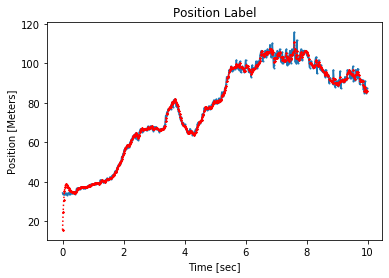

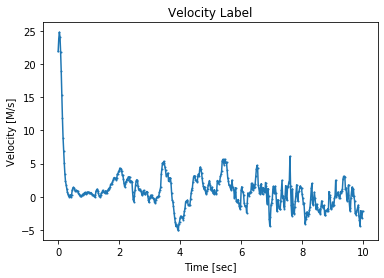

In [41]:
! make 
! mv DvKalman.csv DvKalmanCPU.csv

import matplotlib.pyplot as plt
import pandas as pd

def plot_results(filename):
    df = pd.read_csv(filename)
    plot_1, ax = plt.subplots()
    plot_2, vel= plt.subplots()
    
    vel.plot(df.Time.to_list(), df.Velocity.to_list(), 'o-', label="Measurements", markersize=1)
    vel.set(title="Velocity Label", xlabel="Time [sec]", ylabel="Velocity [M/s]")

    ax.plot(df.Time.to_list(), df.Measurements.to_list(), 'o-', label="Kalman Filter", markersize=1) 
    ax.plot(df.Time.to_list(), df.Position.to_list(), 'r:*', label="Measurements", markersize=2)
    ax.set(title="Position Label", xlabel="Time [sec]", ylabel="Position [Meters]")
    

plot_results('DvKalmanCPU.csv')

# GPU execution

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 60 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
963175.v-qsvr-1            ...ub-singleuser u81855          00:01:27 R jupyterhub     
963195.v-qsvr-1            build_run.sh     u81855                 0 Q batch          

Waiting for Output ████████████████████████ Done⬇

########################################################################
#      Date:           Wed 08 Sep 2021 06:54:15 PM PDT
#    Job ID:           963195.v-qsvr-1.aidevcloud
#      User:           u81855
# Resources:           neednodes=1:gpu:ppn=2,nodes=1:gpu:ppn=2,walltime=06:00:00
########################################################################

./DvKalman
Device: Intel(R) UHD Graphics P

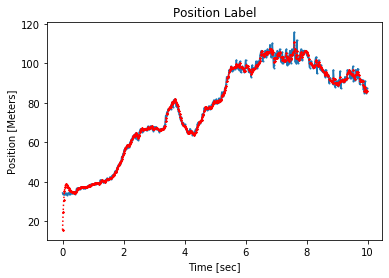

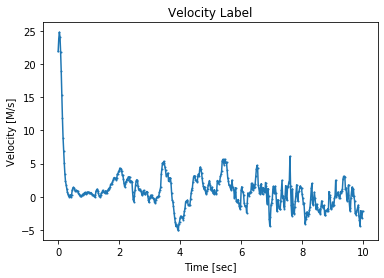

In [42]:
! chmod 755 q; chmod 755 build_run.sh; if [ -x "$(command -v qsub)" ]; then ./q build_run.sh; else ./build_run.sh; fi
! mv DvKalman.csv DvKalmanGPU.csv

plot_results('DvKalmanGPU.csv')